In [1]:
# 코드 2-1 필요한 라이브러리 호출
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

2024-12-03 00:51:48.419496: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 00:51:48.424164: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 00:51:48.431704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733154708.442968   78724 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733154708.446400   78724 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 00:51:48.461487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# 코드 2-2 데이터 호출
cols = ["price", "maint", "doors", "persons", "lug_capacity", "safety", "output"]
cars = pd.read_csv("../chap2/data/car_evaluation.csv", names=cols, header=None)

<Axes: ylabel='count'>

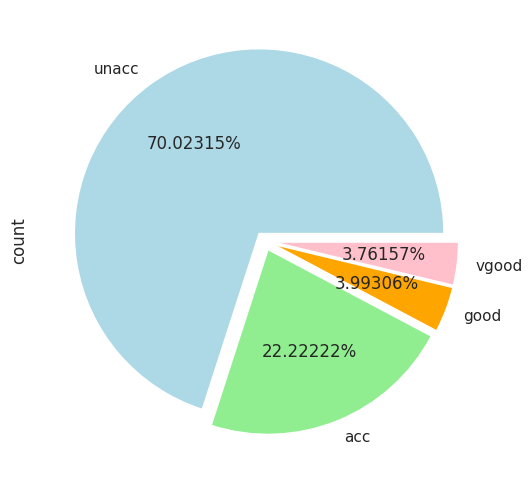

In [3]:
# 코드 2-3 예제 데이터셋 분포
plot_size = plt.rcParams["figure.figsize"]
plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size
cars.output.value_counts().plot(
    kind="pie",
    autopct="%0.05f%%",
    colors=["lightblue", "lightgreen", "orange", "pink"],
    explode=(0.05, 0.05, 0.05, 0.05),
)

In [4]:
# 코드 2-4 원-핫 인코딩 적용
# 범주 정보를 숫자로 변환해야 하기에 원-핫 인코딩를 사용한다.
# 원-핫 인코딩이란 범주형 데이터를 0과 1로 이루어진 이진 벡터로 변환하는 것이다.
# 하나만 불을 켜고 나머지는 끄는 방식이다.
# get_dummies는 가변수를 만들어주는 함수

price = pd.get_dummies(cars.price, prefix="price")
maint = pd.get_dummies(cars.maint, prefix="maint")

doors = pd.get_dummies(cars.doors, prefix="doors")
persons = pd.get_dummies(cars.persons, prefix="persons")

lug_capacity = pd.get_dummies(cars.lug_capacity, prefix="lug_capacity")
safety = pd.get_dummies(cars.safety, prefix="safety")

labels = pd.get_dummies(cars.output, prefix="condition")

X = pd.concat([price, maint, doors, persons, lug_capacity, safety], axis=1)
y = labels.values

In [5]:
X

,price_high,price_low,price_med,price_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_capacity_big,lug_capacity_med,lug_capacity_small,safety_high,safety_low,safety_med
0,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,False,True,False,True,False
1,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,False,True,False,False,True
2,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,False,True,True,False,False
3,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,True,False,False,True,False
4,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,False,True,False,False,False,True,False,False,False,False,...,True,False,False,True,False,True,False,False,False,True
1724,False,True,False,False,False,True,False,False,False,False,...,True,False,False,True,False,True,False,True,False,False
1725,False,True,False,False,False,True,False,False,False,False,...,True,False,False,True,True,False,False,False,True,False
1726,False,True,False,False,False,True,False,False,False,False,...,True,False,False,True,True,False,False,False,False,True


In [6]:
y

array([[False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       ...,
       [False, False,  True, False],
       [False,  True, False, False],
       [False, False, False,  True]])

In [7]:
# 코드 2-5 훈련과 검증 데이터셋으로 분리
from sklearn.model_selection import train_test_split

# 하이퍼파라미터 튜닝을 위해 훈련 데이터와 테스트 데이터로 나눈다.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [8]:
# 코드 2-6 모델 생성 및 컴파일
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

# 입력층 (Input layer)
# 입력 데이터의 형태를 지정합니다. 여기서 X.shape[1]은 입력 데이터의 특성 수를 의미합니다.
input_layer = Input(shape=(X.shape[1],))

# 첫 번째 은닉층 (First hidden layer)
# 15개의 뉴런을 가지고 있으며, 활성화 함수로 ReLU를 사용합니다.
dense_layer_1 = Dense(15, activation="relu")(input_layer)

# 두 번째 은닉층 (Second hidden layer)
# 10개의 뉴런을 가지고 있으며, 활성화 함수로 ReLU를 사용합니다.
dense_layer_2 = Dense(10, activation="relu")(dense_layer_1)

# 출력층 (Output layer)
# 출력 데이터의 형태를 지정합니다. 여기서 y.shape[1]은 출력 데이터의 클래스 수를 의미합니다.
# 활성화 함수로 소프트맥스(softmax)를 사용하여 다중 클래스 분류를 수행합니다.
output = Dense(y.shape[1], activation="softmax")(dense_layer_2)

# 모델 구성 및 컴파일 (Model construction and compilation)
# 입력층과 출력층을 지정하여 모델을 구성합니다.
# 손실 함수로 categorical_crossentropy를 사용하고, 옵티마이저로 adam을 사용합니다.
# 평가 지표로 정확도(acc)를 사용합니다.
model = Model(inputs=input_layer, outputs=output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

# 모델 요약 (Model summary)
# 모델의 구조를 출력합니다.
model.summary()

W0000 00:00:1733154805.750696   78724 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 534 (2.09 KB)

 Trainable params: 534 (2.09 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 코드 2-7 모델 훈련
# 모델 훈련 (Model training)
# model.fit() 메서드를 사용하여 모델을 훈련시킵니다.
# X_train: 훈련 데이터의 입력 부분입니다.
# y_train: 훈련 데이터의 출력(레이블) 부분입니다.
# batch_size=8: 배치 크기를 8로 설정합니다. 즉, 한 번에 8개의 샘플을 사용하여 가중치를 업데이트합니다.
# epochs=50: 전체 훈련 데이터셋을 50번 반복하여 학습합니다.
# verbose=1: 훈련 과정의 진행 상황을 출력합니다. 1은 자세한 출력을 의미합니다.
# validation_split=0.2: 훈련 데이터의 20%를 검증 데이터로 사용합니다.
history = model.fit(
    X_train, y_train, batch_size=8, epochs=50, verbose=1, validation_split=0.2
)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.4682 - loss: 1.2457 - val_acc: 0.6498 - val_loss: 0.8692
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.7201 - loss: 0.7031 - val_acc: 0.6498 - val_loss: 0.6867
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.7322 - loss: 0.5342 - val_acc: 0.7112 - val_loss: 0.5694
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8250 - loss: 0.4336 - val_acc: 0.8087 - val_loss: 0.4727
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8591 - loss: 0.3565 - val_acc: 0.8303 - val_loss: 0.4049
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8827 - loss: 0.3027 - val_acc: 0.8556 - val_loss: 0.3618
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.9015 - loss: 0.2403 - val_acc: 0.8556 - val_loss: 0.3257
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.9037 - loss: 0.2468 - val_acc: 0.8700 - val_loss: 0.3001
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - ac

In [10]:
# 코드 2-8 모델 평가
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9530 - loss: 0.1371 
Test Score: 0.10715542733669281
Test Accuracy: 0.9682080745697021
